# **Import Libraries**

In [ ]:
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization, DepthwiseConv2D, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Train Dataset**

In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/Pneumonia.zip

Archive:  /content/drive/MyDrive/Colab_Notebooks/Pneumonia.zip
  inflating: Data_blance/Test/Normal/IM-0006-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0033-0001-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0067-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0070-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0079-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0081-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0086-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0105-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0145-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0147-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0191-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0268-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0325-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0369-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0371-0001.jpeg  
  inflating: Data_blance/Test/Normal/IM-0382-0001.jpeg  
  inflating: Data_bl

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.1, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   width_shift_range=0.10,
                                   height_shift_range=0.10
                                   )
training_set = train_datagen.flow_from_directory('/content/Data_blance/Train', 
                                                 target_size = (512,512), 
                                                 batch_size = 64, 
                                                 #color_mode = 'grayscale' , 
                                                 class_mode = 'categorical')
training_set.class_indices

Found 3900 images belonging to 3 classes.


{'Normal': 0, 'bacteria': 1, 'virus': 2}

# Load Test Dataset

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1.0/255)
test_set = train_datagen.flow_from_directory('/content/Data_blance/Test', 
                                             target_size =(512,512), 
                                             batch_size = 64, 
                                             #color_mode = 'grayscale', 
                                             class_mode = 'categorical')

Found 300 images belonging to 3 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale = 1.0/255)
val_set = train_datagen.flow_from_directory('/content/Data_blance/Val', 
                                             target_size =(512,512), 
                                             batch_size = 64, 
                                             #color_mode = 'grayscale', 
                                             class_mode = 'categorical')

Found 279 images belonging to 3 classes.


# **Countplot**

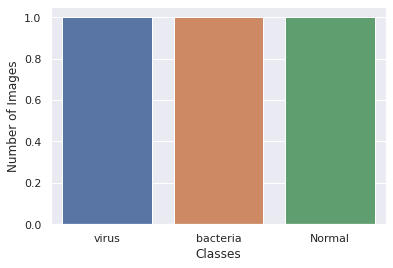

In [ ]:
path = '/content/Data_blance/Train'

class_counts = {}

for subdir in os.listdir(path):
    subdir_path = os.path.join(path, subdir)
    class_counts[subdir] = len(os.listdir(subdir_path))

sns.countplot(x=list(class_counts.keys()), data=None)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.show()


# **Visualize Images**

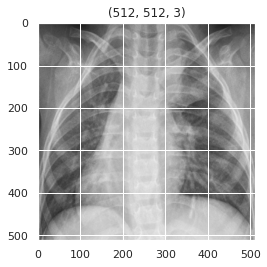

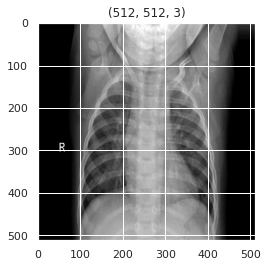

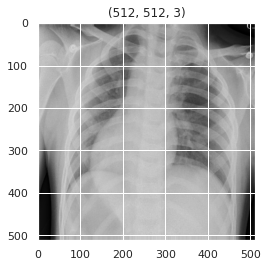

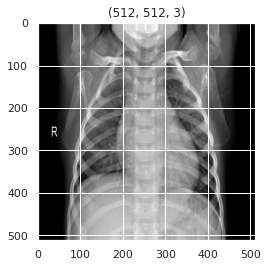

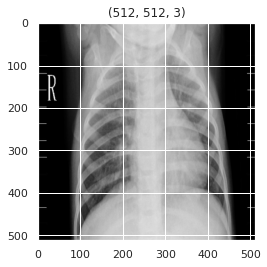

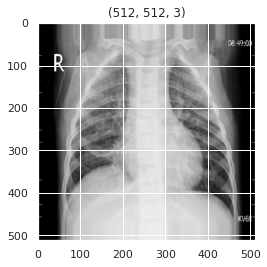

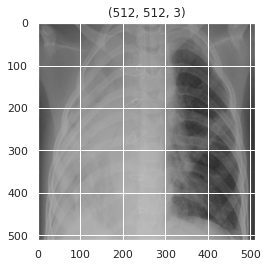

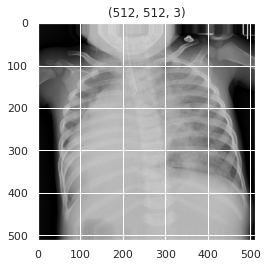

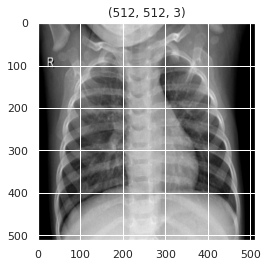

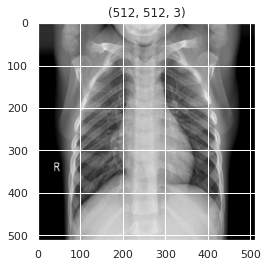

In [ ]:
t_img , label = training_set.next()

def plotImages(img_arr, label):
  count = 0
  for im, l in zip(img_arr,label) :
    plt.imshow(im)
    plt.title(im.shape)
    plt.axis = False
    plt.show()
    
    count += 1
    if count == 10:
      break

plotImages(t_img, label)

# **Model Building**

In [ ]:
base_model = InceptionV3(input_shape = (512, 512, 3), include_top = False, weights = 'imagenet')

for layer in base_model.layers[:-10]:
    layer.trainable = False

for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output

x= Conv2D(filters = 128, kernel_size = (1,1),strides=(1,1))(x)
x = Activation('relu')(x)

x= Conv2D(filters = 64, kernel_size = (3,3))(x)
x = Activation('relu')(x)

x= Conv2D(filters = 128, kernel_size = (3,3))(x)
x = Activation('relu')(x)
x= MaxPool2D(pool_size = (2,2))(x)

x = Flatten()(x)

x = Dense(units = 128)(x)
x = Activation('relu')(x)
x= Dropout(0.3)(x)

x = Dense(units = 64)(x)
x = Activation('relu')(x)
x= Dropout(0.3)(x)

x = Dense(units = 3 , activation = 'softmax' )(x)

model = Model(base_model.input, outputs = x)

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_375 (Conv2D)            (None, 255, 255, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_392 (Batch  (None, 255, 255, 32  96         ['conv2d_375[0][0]']             
 Normalization)                 )                                                           

# **Model Training**

In [ ]:
print(len(test_set))
print(len(training_set))
print(len(val_set))

5
61
5


In [ ]:
history=model.fit(training_set, validation_data = val_set, epochs =20)

Epoch 1/20
61/61 [==============================] - 343s 5s/step - loss: 0.7918 - accuracy: 0.5982 - val_loss: 0.6291 - val_accuracy: 0.7455
Epoch 2/20
61/61 [==============================] - 286s 5s/step - loss: 0.5829 - accuracy: 0.7505 - val_loss: 0.5970 - val_accuracy: 0.7634
Epoch 3/20
61/61 [==============================] - 286s 5s/step - loss: 0.5446 - accuracy: 0.7756 - val_loss: 0.5844 - val_accuracy: 0.7634
Epoch 4/20
61/61 [==============================] - 286s 5s/step - loss: 0.5050 - accuracy: 0.7846 - val_loss: 0.5497 - val_accuracy: 0.7849
Epoch 5/20
61/61 [==============================] - 285s 5s/step - loss: 0.4965 - accuracy: 0.7882 - val_loss: 0.5813 - val_accuracy: 0.7706
Epoch 6/20
61/61 [==============================] - 284s 5s/step - loss: 0.4855 - accuracy: 0.7931 - val_loss: 0.5171 - val_accuracy: 0.7742
Epoch 7/20
61/61 [==============================] - 286s 5s/step - loss: 0.4525 - accuracy: 0.8062 - val_loss: 0.5640 - val_accuracy: 0.7778
Epoch 8/20
61

In [ ]:
#model.save('/content/drive/MyDrive/Colab_Notebooks/DL Model/pneumonia_tl.h5') 
model = load_model('/content/drive/MyDrive/Colab_Notebooks/DL Model/pneumonia_tl.h5')

# **Accuracy and Loss Comparison**

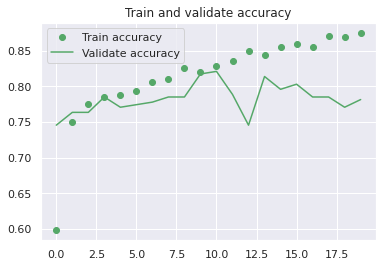

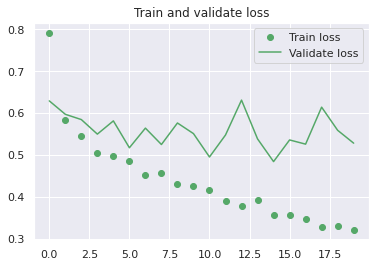

In [ ]:
acc = history.history['accuracy']                          
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot( acc, 'go', label='Train accuracy')
plt.plot( val_acc, 'g', label='Validate accuracy')
plt.title('Train and validate accuracy')
plt.legend()                                           

plt.figure()
plt.plot( loss, 'go', label='Train loss')
plt.plot( val_loss, 'g', label='Validate loss')
plt.title('Train and validate loss')
plt.legend()
plt.show() 

# **Model Evaluation**

In [ ]:
results=model.evaluate(test_set,verbose=True)
print(f'Test results - Loss: {results[0]} - Accuracy: {100*results[1]}%')

5/5 [==============================] - 26s 5s/step - loss: 0.4843 - accuracy: 0.8233
Test results - Loss: 0.4843422472476959 - Accuracy: 82.33333230018616%


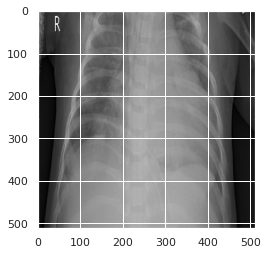

1/1 [==============================] - 0s 136ms/step
The predicted class is: virus


In [ ]:
class_names = ['Normal', 'bacteria', 'virus'] 

image = load_img('/content/Data_blance/Test/virus/person1455_virus_2489.jpeg', target_size=(512,512))
input_arr = img_to_array(image)
input_arr = np.array([input_arr]) 
plt.imshow(image)
plt.show()

pred_probabilities = model.predict(input_arr)[0]
predicted_class_index = np.argmax(pred_probabilities)

predicted_class_name = class_names[predicted_class_index]
print(f"The predicted class is: {predicted_class_name}")